## Sydney Basin Thunderstorm Climatology based on GPATS data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

get_ipython().run_line_magic('matplotlib', 'inline')
# %matplotlib notebook for interactivity
import utility_functions_sep2018 as bous

'''
Just change station id variable to generate plots for other airports
'''

sta='YSSY' # change to explore fog plots for other locations
cur_dir='/home/accounts/qdisplay/avguide/app/data'
cur_dir='/home/bou/shared/stats-R/flask_projects/avguide/app/data'

In [58]:
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
# resample data to 1 min (just minimises memory footprint/performance)
# no real impact to data interpretatability
g = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
    .resample('1min')\
    .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
    .dropna()
g.tail()

,LATITUDE,LONGITUDE,AMP
TM,,,
2020-09-21 11:21:00,-34.08744,151.048970,2
2020-09-21 11:23:00,-34.01508,151.140063,3
2020-09-21 11:24:00,-34.10694,151.117870,1
2020-09-21 11:25:00,-34.10632,151.084110,2
2020-09-21 11:28:00,-34.05155,151.145890,1


In [59]:
# daily gpats data counts
# g_ms.resample('D')['AMP'].count().tail(10) (if using raw millisecond gpats data)
g.resample('D')['AMP'].sum().tail(10)

TM
2020-09-12     0
2020-09-13     0
2020-09-14     0
2020-09-15     0
2020-09-16     0
2020-09-17     0
2020-09-18     0
2020-09-19     0
2020-09-20     0
2020-09-21    26
Freq: D, Name: AMP, dtype: int64

In [63]:
# resample introduce ALL days regardless TS/gpats 
# We drop those days with no strikes or even 1 strike (cud be spurious)
# note a sum() here is appropriate, as would be count() but with lower values obviously
g_tmp = g.resample('D')['AMP'].sum()
g_ts_days = g_tmp.loc[g_tmp>1]
g_ts_days.tail(10)

TM
2020-05-13    17
2020-05-21    27
2020-06-07     4
2020-06-21     3
2020-07-02     2
2020-07-12     6
2020-07-13     4
2020-08-12     5
2020-09-04     4
2020-09-21    26
Name: AMP, dtype: int64

In [65]:
# Now we have all the dates when we had storms 
# we just group by month and count how many days we get TS month to get monthly summaries
# sum() not appripriate here as this would add up all gpats strikes
# we want to add days, not how gpats in days/months
g_month_activity = g_ts_days.groupby(g_ts_days.index.month).sum()
g_month = g_ts_days.groupby(g_ts_days.index.month).count()
g_month

TM
1     48
2     44
3     45
4     33
5     17
6     21
7     16
8     13
9     20
10    38
11    48
12    47
Name: AMP, dtype: int64

In [66]:
# We can normalise gpats count per month by days with TS to get sense of 
# how lightning active each month is
# Dec and Jan is most lightning active, followed 2nd place Nov, then 3rd place Feb/Mar 
round(g_month_activity/g_month, 1)

TM
1     163.4
2     117.7
3     114.8
4      76.3
5      38.8
6      19.2
7      22.5
8      37.1
9      43.6
10     91.7
11    136.1
12    160.7
Name: AMP, dtype: float64

In [67]:
# Normalise total monthly thunder days (divide by num of years) to average monthly thunder days
# rounded to 1 DP, Nov,Dec,Jan on average has about 4 thunder days every year
# Oct, Feb, Mar not too far behind (avg ~ 3.5 thunder days) 
round((g_month/12),1)

TM
1     4.0
2     3.7
3     3.8
4     2.8
5     1.4
6     1.8
7     1.3
8     1.1
9     1.7
10    3.2
11    4.0
12    3.9
Name: AMP, dtype: float64

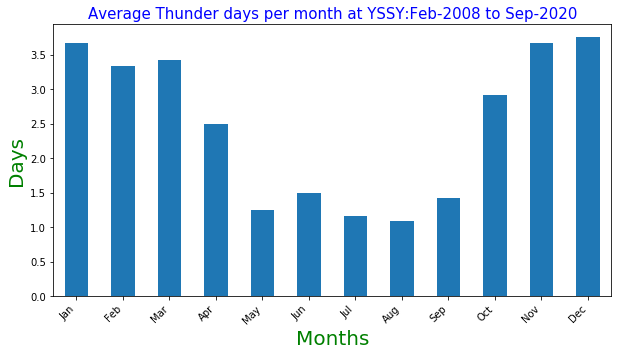

In [71]:
# see Fig 1.1 http://webnsw.bom.gov.au/samu/samu_operational/directives/SAMU_Thunderstorm_Directive.pdf
# that figure is for 1939 to 2014 Average Thunder days per nonth
# trends are similar - peak about 4.0 in Nov/Dec/Jab, so 4 days with TS in these months (about 13%)
# we have more broad peak Jan to Mar and Oct to Dec

dict_mon = dict(zip(
    [1,2,3,4,5,6,7,8,9,10,11,12],
    ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]))

dat = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
    .resample('D')['AMP'].count()
ts_days = dat.loc[dat>2]
avg_mon_ts_days = ts_days.groupby(ts_days.index.month).count()/12


fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
avg_mon_ts_days.plot( kind='bar', ax=ax)
title = f'Average Thunder days per month at YSSY:\
{ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Days', color='g', fontsize=20)
ax.set_xlabel('Months', color='g', fontsize=20)
# g.get_xticks() [ 0  1  2  3  4  5  6  7  8  9 10]

xlabels=[dict_mon[x+1] for x in ax.get_xticks()]
    
# xlabels=list( map( lambda x : dict_mon[x], ax.get_xticks()+2) )  # both give same result
# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
#g.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

In [72]:
# Assuming 30 days per month, this is the climatological probability storms 
# in any given month
# Nov,Dec,Jan has 13% chance of storms on any given day - quite high!
round((g_month/(12*30))*100,2)

TM
1     13.33
2     12.22
3     12.50
4      9.17
5      4.72
6      5.83
7      4.44
8      3.61
9      5.56
10    10.56
11    13.33
12    13.06
Name: AMP, dtype: float64

In [73]:
# Average thunder days annually (bit more than what average annual thunder days map suggests)
# see climate_averages thunder-lightning map below
sum(g_month/12)

32.5

## http://www.bom.gov.au/climate/averages/climatology/thunder
- based on analysis using 10 years of data 1990 to 1999 
- about 20 years old data so not as reliable probably

![](http://www.bom.gov.au/climate/averages/climatology/thunder/tdays.png)

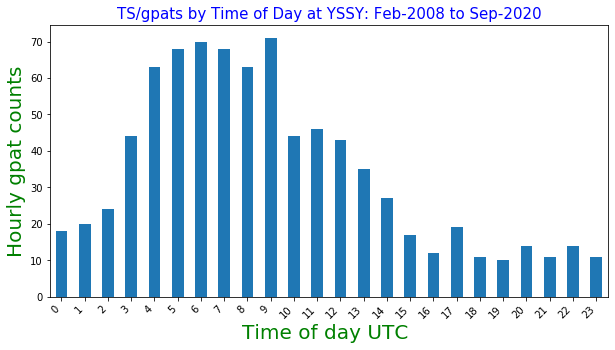

In [77]:
# note resample by default introduces observations/rows in dataset 
# in this case resample('1min') and aggregate makes no difference to actual counts
g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
          .resample('1min')\
          .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
          .dropna()\
          .resample('H')['AMP'].count()
g1_hour = g1_hour.loc[g1_hour>1]
gpats_by_hour = g1_hour.groupby(g1_hour.index.hour).count() # NB not sum() !
# gpats_by_hour/24


fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
gpats_by_hour.plot( kind='bar', ax=ax)
title = f'TS/gpats by Time of Day at YSSY: {ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Hourly gpat counts', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)
# g.get_xticks() [ 0  1  2  3  4  5  6  7  8  9 10]

xlabels=[x for x in ax.get_xticks()]
    
# xlabels=list( map( lambda x : dict_mon[x], ax.get_xticks()+2) )  # both give same result

# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
#g.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

In [33]:
dict_mon
keys = list(dict_mon.keys())
vals = list(dict_mon.values())
print(keys[vals.index('Oct')])
print(keys[vals.index('Nov')])

10
11


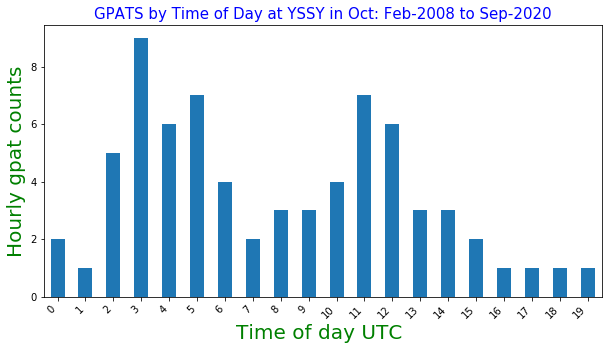

In [37]:
# note resample by default introduces observations/rows in dataset 
# in this case resample('1min') and aggregate makes no difference to actual counts
g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
          .resample('1min')\
          .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
          .dropna()\
          .resample('H')['AMP'].count()

#g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
#          .resample('H')['AMP'].count()

g1_hour = g1_hour.loc[g1_hour>1]   # only keep data with > 1 gpat count per hour

# hourly trend for October only
mon=keys[vals.index('Oct')]
g1_hour = g1_hour.loc[g1_hour.index.month==mon]  
gpats_by_hour = g1_hour.groupby(g1_hour.index.hour).count()
# gpats_by_hour/24


fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
gpats_by_hour.plot( kind='bar', ax=ax)
title = f'GPATS by Time of Day at {sta} in {dict_mon[mon]}: \
{ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Hourly gpat counts', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)
# g.get_xticks() [ 0  1  2  3  4  5  6  7  8  9 10]

xlabels=[x for x in ax.get_xticks()]
    
# xlabels=list( map( lambda x : dict_mon[x], ax.get_xticks()+2) )  # both give same result

# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels,rotation=45, horizontalalignment='right')
#g.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.tick_params(labelsize=10)

In [38]:
'''
resample data to 1min
 nb the counts would obviously be smaller given we not counting millisecond precision strikes
 good thing is we get max 1 gpats count for any minute , so its either 0 or 1
 giving max gpats count 60 in an hour, anythin in range 0 to 60
'''
g1_day = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
      .resample('1min')\
      .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
      .dropna()\
      .resample('D')['AMP'].count()
g1_day.tail()

TM
2020-09-17     0
2020-09-18     0
2020-09-19     0
2020-09-20     0
2020-09-21    11
Freq: D, Name: AMP, dtype: int64

In [39]:
# drop days with no gpats
g1_day = g1_day.loc[g1_day>2]
g1_day.tail(10)

TM
2020-04-30     5
2020-05-13    13
2020-05-21    24
2020-06-07     4
2020-06-21     3
2020-07-12     6
2020-07-13     4
2020-08-12     5
2020-09-04     3
2020-09-21    11
Name: AMP, dtype: int64

In [40]:
g1_month = g1_day.groupby(g1_day.index.month).count()
g1_month

TM
1     43
2     39
3     41
4     28
5     15
6     16
7     13
8     13
9     16
10    34
11    44
12    45
Name: AMP, dtype: int64

TM
1     3.583333
2     3.250000
3     3.416667
4     2.333333
5     1.250000
6     1.333333
7     1.083333
8     1.083333
9     1.333333
10    2.833333
11    3.666667
12    3.750000
Name: AMP, dtype: float64


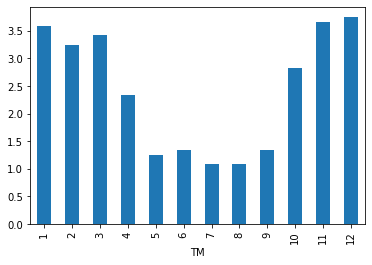

In [41]:
print((g1_month/12))
(g1_month/12).plot(kind='bar')

In [42]:
# note resample introduces hours in dataset even when no gpats
g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM').\
          resample('H')['AMP'].count()
g1_hour.tail()

TM
2020-09-21 07:00:00     0
2020-09-21 08:00:00     0
2020-09-21 09:00:00     0
2020-09-21 10:00:00     1
2020-09-21 11:00:00    25
Freq: H, Name: AMP, dtype: int64

In [43]:
# to check out any specific day - gpats count for each hour on that date
g1_hour.loc['29-03-2008']

TM
2008-03-29 00:00:00     0
2008-03-29 01:00:00     0
2008-03-29 02:00:00     0
2008-03-29 03:00:00     0
2008-03-29 04:00:00     0
2008-03-29 05:00:00     0
2008-03-29 06:00:00    14
2008-03-29 07:00:00     3
2008-03-29 08:00:00     0
2008-03-29 09:00:00     2
2008-03-29 10:00:00    19
2008-03-29 11:00:00    53
2008-03-29 12:00:00     7
2008-03-29 13:00:00     0
2008-03-29 14:00:00     3
2008-03-29 15:00:00     2
2008-03-29 16:00:00     0
2008-03-29 17:00:00     0
2008-03-29 18:00:00     0
2008-03-29 19:00:00     0
2008-03-29 20:00:00     0
2008-03-29 21:00:00     0
2008-03-29 22:00:00     0
2008-03-29 23:00:00     0
Freq: H, Name: AMP, dtype: int64

In [44]:
# drop hours when no gpats
g1_hour = g1_hour[g1_hour>0]
g1_hour.loc['29-03-2008']

TM
2008-03-29 06:00:00    14
2008-03-29 07:00:00     3
2008-03-29 09:00:00     2
2008-03-29 10:00:00    19
2008-03-29 11:00:00    53
2008-03-29 12:00:00     7
2008-03-29 14:00:00     3
2008-03-29 15:00:00     2
Name: AMP, dtype: int64

In [45]:
# get gpats count by hour for for each hour over all days/years
gpats_by_hour = g1_hour.groupby(g1_hour.index.hour).count()
gpats_by_hour/24

TM
0     1.208333
1     1.250000
2     1.541667
3     2.458333
4     3.500000
5     3.750000
6     3.666667
7     3.500000
8     3.750000
9     3.875000
10    2.500000
11    2.583333
12    2.375000
13    1.875000
14    1.833333
15    1.166667
16    0.750000
17    1.125000
18    0.916667
19    0.791667
20    0.916667
21    0.625000
22    0.875000
23    0.833333
Name: AMP, dtype: float64

Text(0.5, 0, 'Time of day UTC ')

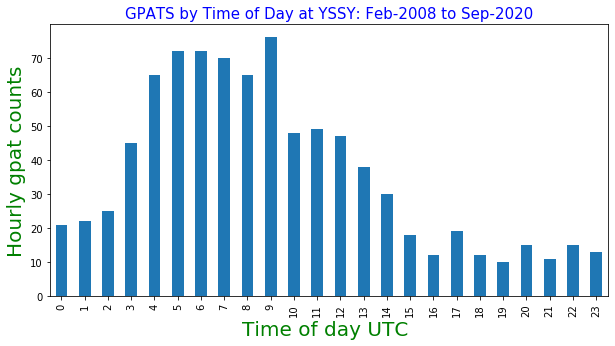

In [55]:
# see also fig 1.2  http://webnsw.bom.gov.au/samu/samu_operational/directives/SAMU_Thunderstorm_Directive.pdf
# very similar trends to whats here

fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
#gpats_by_hour.plot( kind='bar', ax=ax)
g1_hour.groupby(g1_hour.index.hour).count().plot(kind='bar', ax=ax)
title = f'GPATS by Time of Day at {sta}: \
{ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Hourly gpat counts', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)


GPATS data from 2008-02-26 06:00:00 to 2020-09-21 11:00:00


Text(0.5, 0, 'Time of day UTC ')

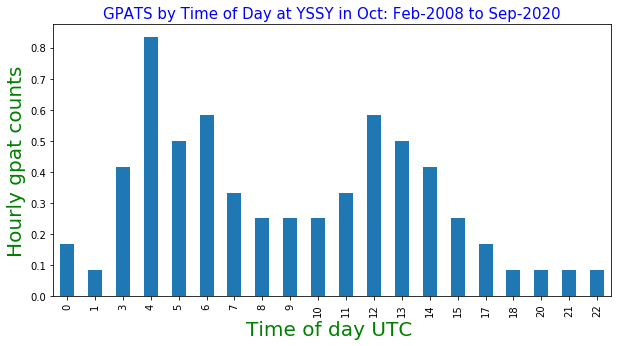

In [54]:
g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
          .resample('H')['AMP'].count()
g1_hour = g1_hour.loc[g1_hour>1]   # only keep data with > 1 gpat count per hour


print(f'GPATS data from {g1_hour.index[0]} to {g1_hour.index[-1]}')

# Filter for October storms hourly trend
mon=keys[vals.index('Oct')]
g1_oct = g1_hour.loc[g1_hour.index.month==mon]  # hourly trend for October only

gpats_by_hour = g1_oct.groupby(g1_oct.index.hour).count()


# normalise for 12 years
fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1 )
(g1_oct.groupby(g1_oct.index.hour).count()/12).plot(kind='bar', ax=ax)
title = f'GPATS by Time of Day at {sta} in {dict_mon[mon]}: \
{ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Hourly gpat counts', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)


For month of October, on average 
- storms observed about 6 days in Oct hours 3-4Z
- storms observed about 11-12 days in Oct hours 4-5Z
- peak 3 to 7Z

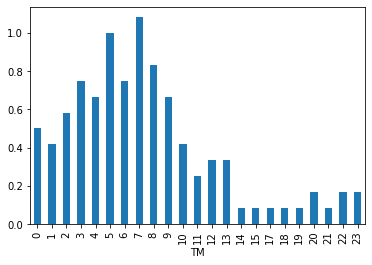

In [22]:
# November hourly trend 
mon=keys[vals.index('Dec')]
g1_dec = g1_hour.loc[g1_hour.index.month==mon]
(g1_dec.groupby(g1_dec.index.hour).count()/12).plot(kind='bar')

For month of November, on average 
- storms observed about 7 days in Oct hours 2-4Z
- storms observed about 11-12 days in Oct hours 4-5Z
- peak 4 to 7Z , about 15 to 18 days have storms on average between these hours in Nov!

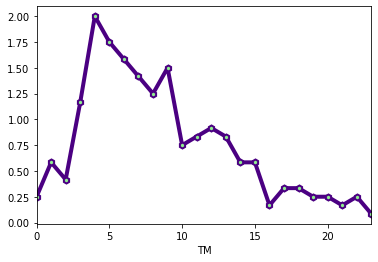

In [48]:
# to see hourly variation by season
spring = (g1_hour.index.month == 9) | (g1_hour.index.month == 10) | (g1_hour.index.month == 11)
summer = (g1_hour.index.month == 12) | (g1_hour.index.month == 1) | (g1_hour.index.month == 2)
autumn = (g1_hour.index.month == 3) | (g1_hour.index.month == 4) | (g1_hour.index.month == 5)
winter = (g1_hour.index.month == 6) | (g1_hour.index.month == 7) | (g1_hour.index.month == 8)

g1_hour = pd.read_csv(gpats_file,parse_dates=True, index_col='TM')\
          .resample('H')['AMP'].count()
g1_hour = g1_hour.loc[g1_hour>1]   # only keep data with > 1 gpat count per hour
g1_spring = g1_hour.loc[spring]
(g1_spring.groupby(g1_spring.index.hour).count()/12).plot(kind='line', color='#4b0082', linewidth=4,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

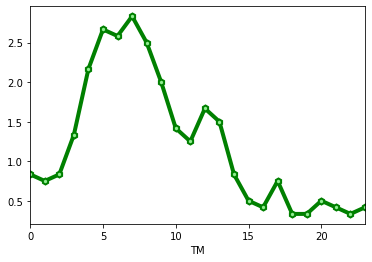

In [24]:

g1_summer = g1_hour.loc[summer]
(g1_summer.groupby(g1_summer.index.hour).count()/12).plot(kind='line', color='green', linewidth=4,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

Text(0.5, 0, 'Time of day UTC ')

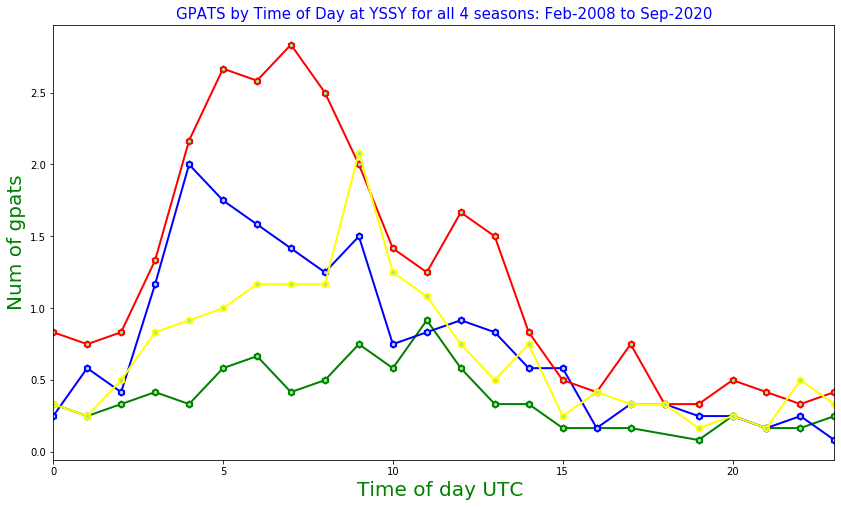

In [25]:

g1_autumn = g1_hour.loc[autumn]

g1_winter = g1_hour.loc[winter]

fig, ax = plt.subplots(figsize=(14,8), nrows=1, ncols=1 )

(g1_winter.groupby(g1_winter.index.hour).count()/12).plot(kind='line', color='green', linewidth=2,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)
(g1_spring.groupby(g1_spring.index.hour).count()/12).plot(kind='line', color='blue', linewidth=2,
         marker='h', markerfacecolor='lightblue', markeredgewidth=2)
(g1_summer.groupby(g1_summer.index.hour).count()/12).plot(kind='line', color='red', linewidth=2,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)
(g1_autumn.groupby(g1_autumn.index.hour).count()/12).plot(kind='line', color='yellow', linewidth=2,
         marker='h', markerfacecolor='lightgreen', markeredgewidth=2)

title = f'GPATS by Time of Day at {sta} for all 4 seasons: \
{ts_days.index[0].strftime("%b-%Y")} to {ts_days.index[-1].strftime("%b-%Y")}'
ax.set_title(title, color='b',fontsize=15)
ax.set_ylabel('Num of gpats', color='g', fontsize=20)
ax.set_xlabel('Time of day UTC ', color='g', fontsize=20)

In [26]:
# def get_gpats_data(cur_dir:str="./gpats_data/",sta:str="YBBN")->pd.DataFrame:
yssy = bous.get_gpats_data(cur_dir=cur_dir,sta='YSSY')\
       .resample('D')['AMP'].count()
yssy = yssy.loc[yssy>1]  # only count days as storm days if more than 2 gpats regsitered
print(yssy.tail())
print(f'Number of storm days in YSSY {len(yssy.index)},  {len(set(yssy.index))}')

ysri = bous.get_gpats_data(cur_dir=cur_dir,sta='YSRI')\
       .resample('D')['AMP'].count()
ysri = ysri.loc[ysri>1]  # only count days as storm days if more than 2 gpats regsitered
print(ysri.tail())
print(f'Number of storm days in ysri {len(ysri.index)},  {len(set(ysri.index))}')

yscn = bous.get_gpats_data(cur_dir=cur_dir,sta='YSCN')\
       .resample('D')['AMP'].count()
yscn = yscn.loc[yscn>1]  # only count days as storm days if more than 2 gpats regsitered
print(yscn.tail())
print(f'Number of storm days in ysbk {len(yscn.index)},  {len(set(yscn.index))}')


ysbk = bous.get_gpats_data(cur_dir=cur_dir,sta='YSBK')\
       .resample('D')['AMP'].count()
ysbk = ysbk.loc[ysbk>1]  # only count days as storm days if more than 2 gpats regsitered
print(ysbk.tail())
print(f'Number of storm days in ysbk {len(ysbk.index)},  {len(set(ysbk.index))}')

yshw = bous.get_gpats_data(cur_dir=cur_dir,sta='YSHW')\
       .resample('D')['AMP'].count()
yshw = yshw.loc[yshw>1]  # only count days as storm days if more than 2 gpats regsitered
print(yshw.tail())
print(f'Number of storm days in yshw {len(yshw.index)},  {len(set(yshw.index))}')

yshl = bous.get_gpats_data(cur_dir=cur_dir,sta='YSHL')\
       .resample('D')['AMP'].count()
yshl = ysri.loc[yshl>1]  # only count days as storm days if more than 2 gpats regsitered
print(yshl.tail())
print(f'Number of storm days in yshl {len(yshl.index)},  {len(set(yshl.index))}')

ywlm = bous.get_gpats_data(cur_dir=cur_dir,sta='YWLM')\
       .resample('D')['AMP'].count()
ywlm = ywlm.loc[ywlm>1]  # only count days as storm days if more than 2 gpats regsitered
print(ywlm.tail())
print(f'Number of storm days in ywlm {len(ywlm.index)},  {len(set(ywlm.index))}')


Reading YSSY gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSSY_10NM.csv
TM
2020-07-12     6
2020-07-13     4
2020-08-12     5
2020-09-04     3
2020-09-21    11
Name: AMP, dtype: int64
Number of storm days in YSSY 384,  384
Reading YSRI gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSRI_10NM.csv
TM
2020-05-21    9
2020-07-13    6
2020-08-08    6
2020-08-12    5
2020-09-04    3
Name: AMP, dtype: int64
Number of storm days in ysri 397,  397
Reading YSCN gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSCN_10NM.csv
TM
2020-04-29     2
2020-05-21    18
2020-07-13     3
2020-08-12     5
2020-09-21    31
Name: AMP, dtype: int64
Number of storm days in ysbk 342,  342
Reading YSBK gpats file /home/bou/shared/stats-R/flask_projects/avguide/app/data/gpats_YSBK_10NM.csv
TM
2020-07-12     7
2020-07-13     5
2020-08-08     5
2020-08-12     8
2020-09-21    25
Name: AMP, dtype: int64
Number of storm days in ysbk 353,  3

Get relative frequeccies
How often SYd gets storms given there are storms at YSRI
COnditional probabilities

Storms YSSY given TS at YSRI
- P(TS YSSY | TS YSRI)
- P(TS YSSY | TS YSCN)

storms at Banks and Holls given TS Camden

- P(TS YSBK | TS YSCN)  or 
- P(TS YSHW | TS YSCN)


Load gpats - get TS dates and set arithmatic to get conditionals

In [27]:
yssy.index

DatetimeIndex(['2008-02-26', '2008-02-27', '2008-02-28', '2008-03-07',
               '2008-03-20', '2008-03-23', '2008-03-25', '2008-03-29',
               '2008-04-13', '2008-05-13',
               ...
               '2020-05-13', '2020-05-21', '2020-06-07', '2020-06-21',
               '2020-07-02', '2020-07-12', '2020-07-13', '2020-08-12',
               '2020-09-04', '2020-09-21'],
              dtype='datetime64[ns]', name='TM', length=384, freq=None)

In [28]:
# removing duplicated from list  
# using collections.OrderedDict.fromkeys() 
from collections import OrderedDict 
res = list(OrderedDict.fromkeys(yssy.index)) 
res[-10:]

[Timestamp('2020-05-13 00:00:00'),
 Timestamp('2020-05-21 00:00:00'),
 Timestamp('2020-06-07 00:00:00'),
 Timestamp('2020-06-21 00:00:00'),
 Timestamp('2020-07-02 00:00:00'),
 Timestamp('2020-07-12 00:00:00'),
 Timestamp('2020-07-13 00:00:00'),
 Timestamp('2020-08-12 00:00:00'),
 Timestamp('2020-09-04 00:00:00'),
 Timestamp('2020-09-21 00:00:00')]

In [29]:
'''
easiest way by which the duplicates are removed from the list - use set()
main drawback is that the ordering of the element is lost in this particular method - 
not too concerned with that here.

set(A).union(set(B)),
set(A).intersection(set(B)),
set(A).symmetric_difference(set(B)),
set(A).difference(set(B)),
set(A).difference(set(B)))
'''

# 227 storm dates in common with ysri and yssy, 20 dates when storms possibly only at ysri
print(f'Number of days with storms at YSRI:{len(set(ysri.index))}\n\
Number of days with storms at YSSY:{len(set(yssy.index))}\n\
Number of days with storms at both locations: {len(set(ysri.index).intersection(set(yssy.index)))}')

Number of days with storms at YSRI:397
Number of days with storms at YSSY:384
Number of days with storms at both locations: 251


In [30]:
# set symmetric_difference - dates which are not common to both sets (associative)
# dates which appear in either one of the sets but not in both 
# (so not common or opposite of intersection)
print(f'Number of days storms at only YSSY or only YSRI but not at both locations \
{len(set(ysri.index).symmetric_difference(set(yssy.index)))},\
{len(set(yssy.index).symmetric_difference(set(ysri.index)))}')

Number of days storms at only YSSY or only YSRI but not at both locations 279,279


In [31]:

'''
From these 260 days, how many are in yssy alone and hom many in ysri only
The set difference of A and B is a set of dates that exists only in set A but not in B'''
print(f'Number of days storms only at YSRI (and not at YSSY) \
{len(set(ysri.index).difference(set(yssy.index)))}')

print(f'Number of days storms only at YSSY (and not at YSRI) \
{len(set(yssy.index).difference(set(ysri.index)))}')

Number of days storms only at YSRI (and not at YSSY) 146
Number of days storms only at YSSY (and not at YSRI) 133


In [32]:
'''
ysri had 367 storm days, yssy 347 days, of these common dates
i.e Number of days with storms at both locations = 227

Out of these, 140 days when storm only at YSRI but not at YSSY
We want to find out how many days we get storms at YSSY given they were also observed at YSRI

Simple approach 
1. find all dates when had stormsa at YSRI - call this number a
2. find how mnay of these dates storms also at YSSY - b num of days
3. conditional prob P(storm YSSY | storm at YSI) = b/a
'''
print (f'probability of TS at YSSY given TS at YSRI = \
{(len(set(ysri.index)) - len(set(ysri.index).difference(set(yssy.index)))) / len(set(ysri.index)):.2f} or \
{len(set(ysri.index).intersection(set(yssy.index))) / len(set(ysri.index)):.2f}')



probability of TS at YSSY given TS at YSRI = 0.63 or 0.63


In [33]:
print (f'probability of TS at YSSY given TS at YSRI = \
{len(set(ysri.index).intersection(set(yssy.index))) / len(set(ysri.index)):.2f}')
print (f'probability of TS at YSSY given TS at YSCN =\
 {len(set(yscn.index).intersection(set(yssy.index))) / len(set(yscn.index)):.2f}')
print (f'probability of TS at YSSY given TS at YSBK =\
 {len(set(ysbk.index).intersection(set(yssy.index))) / len(set(ysbk.index)):.2f}')
print (f'probability of TS at YSSY given TS at YSHW =\
 {len(set(yshw.index).intersection(set(yssy.index))) / len(set(yshw.index)):.2f}')

probability of TS at YSSY given TS at YSRI = 0.63
probability of TS at YSSY given TS at YSCN = 0.71
probability of TS at YSSY given TS at YSBK = 0.86
probability of TS at YSSY given TS at YSHW = 0.82


THis means that off all the storms that affect YSRI, 63% go on to affect YSSY also,
If a storm is at YSBK, than there is 86% chance that storms will also affect YSSY
Whether these are the same storms or not can be found by comparing TS onset times at two locations
with the condition that storm at upstream locations occurs before storm at downwind  location. 

However 65% of days when have storms at YSSY, we also have storms at YSRI
Does this mean storms form at YSSY and move west to affect YSRI!! 

In [34]:
print (f'probability of TS at YSRI given TS at YSSY = \
{len(set(yssy.index).intersection(set(ysri.index))) / len(set(yssy.index)):.2f}')

probability of TS at YSRI given TS at YSSY = 0.65


In [35]:
sta = 'YSSY'
cur_dir='/home/bou/shared/stats-R/flask_projects/avguide/app/data'
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
df = pd.read_csv(gpats_file, parse_dates=True, index_col='TM')

months = df.index.strftime('%b')
years = df.index.strftime('%Y')
unique_years = pd.Series( df.index.strftime('%Y')).unique()
print(f"Unique years in dataset = {unique_years}")
# Get TS days per year, 1st the silly way
pd.Series(years).value_counts().sort_index()

# smarter way (note both are wrong ways to do this!)
yearly_gpats = df.groupby(df.index.year)[['AMP']].agg('count')
yearly_gpats


Unique years in dataset = ['2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017'
 '2018' '2019' '2020']


,AMP
TM,
2008,3960
2009,2211
2010,1631
2011,1133
2012,1696
2013,2354
2014,5746
2015,5492
2016,5029


In [36]:
'''
Note we can't compare like this across years as some years get more active/severe storms so higher gpats count. 
We only interested in how many storm days (not the severity as in how many gpats strikes were recorded on the day)
'''
sta = 'YSSY'
cur_dir='/home/bou/shared/stats-R/flask_projects/avguide/app/data'
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
df = pd.read_csv(gpats_file, parse_dates=True, index_col='TM').resample('1min')\
          .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
          .dropna()
tmp = df.resample('D')['AMP'].count()
ts_days = tmp.loc[tmp>1]
# we assume we need more than one gpats in a given day to count it as a ts day
print(ts_days.loc['2020':]) # storm days/dates 2020
# many days with only 2 or 3 gpats - cross check with manual obs and see if all okay

ts_days_by_year = ts_days.groupby(ts_days.index.year).count()\
    .to_frame()\
    .rename(columns = {'AMP':'count'})

num_years = len(pd.Series( df.index.strftime('%Y')).unique()) # number of years in dataset
print("\nStorm days Sydney by year\n",ts_days_by_year)
print(f"\nTotal Number of storms days Sydney from \
{df.index[0].strftime('%b-%Y')} to {df.index[-1].strftime('%b-%Y')} : \
{ts_days_by_year.sum().values[0]} days")

print(f"\nAnnual Average TS days in Sydney : {(ts_days_by_year.sum().values[0])/num_years}")

print("See also - http://www.bom.gov.au/jsp/ncc/climate_averages/thunder-lightning/index.jsp")
# meaningless
# ts_days_by_year/len(pd.Series( df.index.strftime('%Y')).unique())


TM
2020-01-06      8
2020-01-07     42
2020-01-15     19
2020-01-16      3
2020-01-20    106
2020-01-23      8
2020-01-26     27
2020-02-02     54
2020-02-15     10
2020-02-18     65
2020-04-10      2
2020-04-30      5
2020-05-13     13
2020-05-21     24
2020-06-07      4
2020-06-21      3
2020-07-02      2
2020-07-12      6
2020-07-13      4
2020-08-12      5
2020-09-04      3
2020-09-21     11
Name: AMP, dtype: int64

Storm days Sydney by year
       count
TM         
2008     34
2009     29
2010     29
2011     26
2012     28
2013     29
2014     39
2015     42
2016     23
2017     30
2018     30
2019     23
2020     22

Total Number of storms days Sydney from Feb-2008 to Sep-2020 : 384 days

Annual Average TS days in Sydney : 29.53846153846154
See also - http://www.bom.gov.au/jsp/ncc/climate_averages/thunder-lightning/index.jsp


In [37]:
ts_days_by_month = ts_days.groupby(ts_days.index.month).count().to_frame()\
    .rename(columns = {'AMP':'count'})

maps = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',\
    7:'Jul',8:'Aug', 9:'Sep', 10:'Oct',11:'Nov',12:'Dec'}   

# better not to crate dict mapping manually - use zip like this
month_map = dict(zip(ts_days.index.month.unique(),\
     ts_days.index.strftime('%b').unique()))

ts_days_by_month.rename(mapper=month_map, axis='index',inplace=True)
#print(ts_days_by_month.rename(mapper=maps, axis='index'))  # just checked out correct as
ts_days_by_month


,count
TM,
Jan,47
Feb,44
Mar,44
Apr,31
May,17
Jun,21
Jul,16
Aug,13
Sep,19


In [38]:
# check that year and month sums/counts checks out
ts_days_by_month.sum()[0]==ts_days_by_year.sum()[0]

True

In [39]:
print(f"Average Thunder days by month\n {ts_days_by_month/num_years}")

Average Thunder days by month
         count
TM           
Jan  3.615385
Feb  3.384615
Mar  3.384615
Apr  2.384615
May  1.307692
Jun  1.615385
Jul  1.230769
Aug  1.000000
Sep  1.461538
Oct  2.923077
Nov  3.615385
Dec  3.615385


In [40]:
sta = 'YSSY'
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
gpats = pd.read_csv(gpats_file,parse_dates=True, index_col='TM').resample('1min')\
          .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
          .dropna()
yssy_times = bous.get_gpats_start_end_duration(gpats)[['first','last']]

sta = 'YSRI'
gpats_file = os.path.join(cur_dir, f'gpats_{sta}_10NM.csv')
gpats = pd.read_csv(gpats_file,parse_dates=True, index_col='TM').resample('1min')\
          .agg(dict(LATITUDE='mean', LONGITUDE='mean', AMP='count'))\
          .dropna()
ysri_times = bous.get_gpats_start_end_duration(gpats)[['first','last']]

In [41]:
ysri_times.index,ysri_times.tail(),yssy_times.tail()

(DatetimeIndex(['2008-02-26', '2008-02-27', '2008-03-07', '2008-03-24',
                '2008-03-25', '2008-03-28', '2008-04-07', '2008-04-13',
                '2008-05-13', '2008-06-19',
                ...
                '2020-02-18', '2020-02-26', '2020-03-25', '2020-04-10',
                '2020-04-29', '2020-05-21', '2020-07-13', '2020-08-08',
                '2020-08-12', '2020-09-04'],
               dtype='datetime64[ns]', name='TM', length=384, freq=None),
                          first                last
 TM                                                
 2020-05-21 2020-05-21 08:12:00 2020-05-21 09:04:00
 2020-07-13 2020-07-13 07:50:00 2020-07-13 13:08:00
 2020-08-08 2020-08-08 08:51:00 2020-08-08 09:07:00
 2020-08-12 2020-08-12 08:43:00 2020-08-12 09:04:00
 2020-09-04 2020-09-04 10:25:00 2020-09-04 10:51:00,
                          first                last
 TM                                                
 2020-07-12 2020-07-12 05:53:00 2020-07-12 13:58:00
 2020-07

In [42]:
merged = pd.merge(left=ysri_times, right=yssy_times,how = 'inner',on='TM')\
    .rename(columns = {'first_x':'ysri_start', 'last_x':'ysri_last', 'first_y':'yssy_start', 'last_y':'yssy_last'})
merged #,merged.shape

,ysri_start,ysri_last,yssy_start,yssy_last
TM,,,,
2008-02-26,2008-02-26 04:08:00,2008-02-26 16:28:00,2008-02-26 06:13:00,2008-02-26 20:29:00
2008-02-27,2008-02-27 07:24:00,2008-02-27 23:47:00,2008-02-27 07:53:00,2008-02-27 23:58:00
2008-03-07,2008-03-07 08:46:00,2008-03-07 13:21:00,2008-03-07 08:38:00,2008-03-07 10:58:00
2008-03-25,2008-03-25 10:47:00,2008-03-25 11:08:00,2008-03-25 05:19:00,2008-03-25 12:19:00
2008-04-13,2008-04-13 01:34:00,2008-04-13 09:51:00,2008-04-13 02:12:00,2008-04-13 09:38:00
...,...,...,...,...
2020-04-10,2020-04-10 07:58:00,2020-04-10 08:03:00,2020-04-10 07:02:00,2020-04-10 07:54:00
2020-05-21,2020-05-21 08:12:00,2020-05-21 09:04:00,2020-05-21 08:02:00,2020-05-21 10:12:00
2020-07-13,2020-07-13 07:50:00,2020-07-13 13:08:00,2020-07-13 09:52:00,2020-07-13 11:11:00


In [43]:
ts_yssy_then_ysri = merged.loc[(merged['ysri_start']>merged['yssy_start'])]
print("Of the common storm days at YSSY and YSRI,\n\
about a 1/4 - 25% of Days storms affect YSRI after YSSY :",\
    ts_yssy_then_ysri.shape[0])

ts_ysri_then_yssy = merged.loc[(merged['yssy_start']>merged['ysri_start'])]
print("\nOf the common storm days at YSSY and YSRI,\n\
about 3/4 - 75% of Days storms affect YSSY after YSRI :",\
    ts_ysri_then_yssy.shape[0])


Of the common storm days at YSSY and YSRI,
about a 1/4 - 25% of Days storms affect YSRI after YSSY : 62

Of the common storm days at YSSY and YSRI,
about 3/4 - 75% of Days storms affect YSSY after YSRI : 175


In [44]:
print(f'About {ts_ysri_then_yssy.shape[0]} days i.e {ts_ysri_then_yssy.shape[0]/merged.shape[0]:.2f}% of days, storms are detected FIRST at Richmond and LATER on at Sydney.\nAverage travel time =  {(ts_ysri_then_yssy["yssy_start"]-ts_ysri_then_yssy["ysri_start"]).mean().seconds/60:.0f} minutes.')

About 175 days i.e 0.74% of days, storms are detected FIRST at Richmond and LATER on at Sydney.
Average travel time =  141 minutes.


In [45]:
# Some days also when storms detected 1st at YSSY and then YSRI
# chech if matches with any easterly sector steering!!
merged.loc[(merged['ysri_start']>merged['yssy_start'])].index

DatetimeIndex(['2008-03-07', '2008-03-25', '2008-08-22', '2008-09-14',
               '2008-11-14', '2008-11-20', '2008-12-18', '2009-01-15',
               '2009-02-21', '2009-03-14', '2009-10-06', '2009-11-12',
               '2010-02-05', '2010-02-12', '2010-02-28', '2010-05-21',
               '2010-12-16', '2011-10-29', '2011-11-08', '2012-01-05',
               '2012-01-08', '2012-02-13', '2012-02-17', '2012-02-19',
               '2012-11-27', '2012-12-25', '2013-01-13', '2013-02-24',
               '2014-02-26', '2014-03-07', '2014-03-24', '2014-04-04',
               '2014-09-16', '2014-10-14', '2015-01-20', '2015-02-12',
               '2015-02-15', '2015-03-01', '2015-03-20', '2015-04-21',
               '2015-12-15', '2015-12-16', '2016-01-25', '2017-06-07',
               '2017-10-22', '2017-10-26', '2017-12-08', '2017-12-16',
               '2018-02-09', '2018-04-02', '2018-06-06', '2018-12-15',
               '2018-12-31', '2019-01-22', '2019-01-27', '2019-03-14',
      